# Homework 08: Expectation-Maximization Clustering
## Kerem Girenes
### May 20, 2022

In [188]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial as spa
from scipy.stats import multivariate_normal as mv_normal

## Importing Data

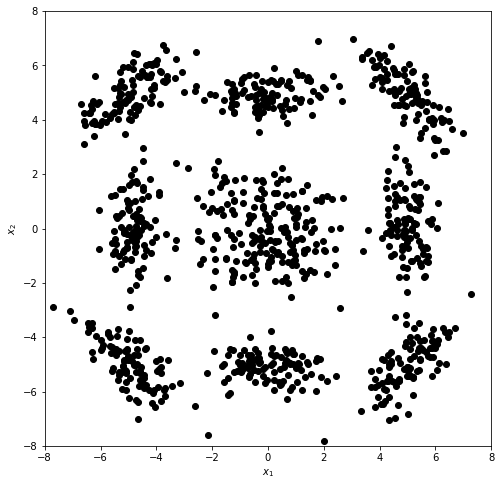

9 [100. 100. 100. 100. 100. 100. 100. 100. 200.] 1000


In [189]:
points = np.genfromtxt("hw08_data_set.csv", delimiter=",")
x1 = points[:, 0]
x2 = points[:, 1]

## Plotting Data Points
plt.figure(figsize=(8, 8))
plt.plot(x1, x2, "k.", markersize=12)
plt.xlim([-8, 8])
plt.ylim([-8, 8])
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

## Nine Distinct Classes
K = 9

## Each with size 100
N_class = np.zeros(K)
N_class[:] = 100

## Except class 9 (which has 200)
N_class[8] = 200

## For a total of 1000 points
N = points.shape[0]

print(K, N_class, N)

## Class Means and Class Covariances

In [190]:
class_means = np.zeros((K,2))
class_cov = np.zeros((K, 2, 2))

class_means[0] = [+5.0, +5.0]
class_means[1] = [-5.0, +5.0]
class_means[2] = [-5.0, -5.0]
class_means[3] = [+5.0, -5.0]
class_means[4] = [+5.0, +0.0]
class_means[5] = [+0.0, +5.0]
class_means[6] = [-5.0, +0.0]
class_means[7] = [+0.0, -5.0]
class_means[8] = [+0.0, +0.0]

class_cov[0] = [[+0.8, -0.6], [-0.6, +0.8]]
class_cov[1] = [[+0.8, +0.6], [+0.6, +0.8]]
class_cov[2] = [[+0.8, -0.6], [-0.6, +0.8]]
class_cov[3] = [[+0.8, +0.6], [+0.6, +0.8]]
class_cov[4] = [[+0.2, +0.0], [+0.0, +1.2]]
class_cov[5] = [[+1.2, +0.0], [+0.0, +0.2]]
class_cov[6] = [[+0.2, +0.0], [+0.0, +1.2]]
class_cov[7] = [[+1.2, +0.0], [+0.0, +0.2]]
class_cov[8] = [[+1.6, +0.0], [+0.0, +1.6]]

print(class_means)
print(class_cov)

[[ 5.  5.]
 [-5.  5.]
 [-5. -5.]
 [ 5. -5.]
 [ 5.  0.]
 [ 0.  5.]
 [-5.  0.]
 [ 0. -5.]
 [ 0.  0.]]
[[[ 0.8 -0.6]
  [-0.6  0.8]]

 [[ 0.8  0.6]
  [ 0.6  0.8]]

 [[ 0.8 -0.6]
  [-0.6  0.8]]

 [[ 0.8  0.6]
  [ 0.6  0.8]]

 [[ 0.2  0. ]
  [ 0.   1.2]]

 [[ 1.2  0. ]
  [ 0.   0.2]]

 [[ 0.2  0. ]
  [ 0.   1.2]]

 [[ 1.2  0. ]
  [ 0.   0.2]]

 [[ 1.6  0. ]
  [ 0.   1.6]]]


## Update Membership Helper

In [191]:
def update_memberships(centroids, X):
    # calculate distances between centroids and data points
    D = spa.distance_matrix(centroids, X)
    # find the nearest centroid for each data point
    memberships = np.argmin(D, axis = 0)
    return memberships

## Initialize EM Algorithm

In [192]:
centroids = np.genfromtxt("hw08_initial_centroids.csv", delimiter=",")
est_memberships = update_memberships(centroids, points)

## Phi Parameters
est_probability = np.array(np.bincount(est_memberships)) / N
est_class_size = np.array(np.bincount(est_memberships))
est_class_cov = np.array([
    np.transpose(np.mat(points[est_memberships == k] - centroids[k])) * np.mat(points[est_memberships == k] - centroids[k]) / est_class_size[k] for k in range(K)])

print("Estimated Initial Class Covariances:\n", est_class_cov)
print("\nEstimated Prior Probabilities:\n", est_probability)

Estimated Initial Class Covariances:
 [[[ 8.43817628  6.14209783]
  [ 6.14209783  5.4965149 ]]

 [[ 3.07126503 -0.02169121]
  [-0.02169121  1.16496993]]

 [[ 7.66513043 -3.30421096]
  [-3.30421096  1.87061185]]

 [[ 2.6893696  -0.79297103]
  [-0.79297103  4.40527123]]

 [[ 0.60942601 -0.1071184 ]
  [-0.1071184   1.0506901 ]]

 [[ 6.36185294 -1.39518868]
  [-1.39518868  1.8532208 ]]

 [[ 3.60946634 -3.53784635]
  [-3.53784635  8.78361705]]

 [[ 2.90313131  1.16592358]
  [ 1.16592358  1.16102739]]

 [[ 1.53605069 -0.02001096]
  [-0.02001096  3.7288816 ]]]

Estimated Prior Probabilities:
 [0.1   0.117 0.067 0.116 0.11  0.167 0.132 0.051 0.14 ]


## E-Step and M-Step Algorithms

In [193]:
def e_step(centroids, est_class_cov, est_probability, points):
    ## Use Multivariate Gaussian Normal function (mv_normal)
    membership_probabilities = np.zeros((N, K))
    for k in range(K):
        for n in range(N):
            denom = np.sum([mv_normal.pdf(points[n], centroids[c], est_class_cov[c]) * est_probability[c] for c in range(K)], axis=0)
            nom = mv_normal.pdf(points[n], centroids[k], est_class_cov[k]) * est_probability[k]
            membership_probabilities[n, k] = nom/denom
    return membership_probabilities

def m_step(points, mp):
    centroids = np.zeros((K, 2))
    est_class_cov = np.zeros((K, 2, 2))
    est_probability = np.zeros(K)

    for k in range(K):
        ## Centroids
        centroids[k] = np.sum([(points[n] * mp[n, k]) for n in range(N)], axis=0) / np.sum(mp[:, k])
        ## Class Covariances
        nom = np.sum([np.multiply(np.matmul(np.transpose(np.asmatrix(points[n] - centroids[k])), np.asmatrix(points[n] - centroids[k])), mp[n, k]) for n in range(N)], axis = 0)
        denom = np.sum(mp[:, k])
        est_class_cov[k] = nom/denom
        ## Probabilities
        est_probability[k] = np.sum(mp[:, k], axis=0) / N

    return centroids, est_class_cov, est_probability

## 100 Iterations

In [194]:
for itn in range(1, 101):
    ## Expectation
    membership_probs = e_step(centroids, est_class_cov, est_probability, points)

    ## Maximization
    centroids, est_class_cov, est_probability = m_step(points, membership_probs)

print("Mean Vectors after 100 iterations:\n", centroids)

Mean Vectors after 100 iterations:
 [[-4.9508988  -4.98464367]
 [-4.85629614  0.0404331 ]
 [-4.96379877  4.984647  ]
 [ 0.02477868 -5.09014979]
 [-0.09548618 -0.116943  ]
 [-0.03701877  4.91812108]
 [ 5.00933942 -5.02595861]
 [ 4.99839618  0.13777844]
 [ 4.96705774  4.97185503]]


## Plot Helper

In [195]:
def plot_current_state(centroids, memberships, X, class_covariances, initial_class_means, initial_covariances):
    cluster_colors = np.array(["#1f78b4", "#33a02c", "#e31a1c", "#ff7f00", "#6a3d9a", "#b15928",
                               "#a6cee3", "#b2df8a", "#fb9a99", "#fdbf6f", "#cab2d6", "#ffff99"])
    if memberships is None:
        plt.plot(X[:,0], X[:,1], ".", markersize = 10, color = "black")
    else:
        for c in range(K):
            plt.plot(X[memberships == c, 0], X[memberships == c, 1], ".", markersize = 10,
                     color = cluster_colors[c])
    for c in range(K):
        plt.plot(centroids[c, 0], centroids[c, 1], "s", markersize = 12,
                 markerfacecolor = cluster_colors[c], markeredgecolor = "black")
    plt.xlabel("x1")
    plt.ylabel("x2")

    x1_grid, x2_grid = np.meshgrid(np.linspace(-8, +8, 1601), np.linspace(-8, +8, 1601))
    intervals = np.dstack((x1_grid, x2_grid))

    for k in range(K):
        em_points = mv_normal(centroids[k], class_covariances[k]).pdf(intervals)
        plt.contour(x1_grid, x2_grid, em_points, colors=cluster_colors[k], levels=[0.05])
        given_points = mv_normal(initial_class_means[k], initial_covariances[k]).pdf(intervals)
        plt.contour(x1_grid, x2_grid, given_points, linestyles='dashed', levels=[0.05], colors='k')


## Plotting Results

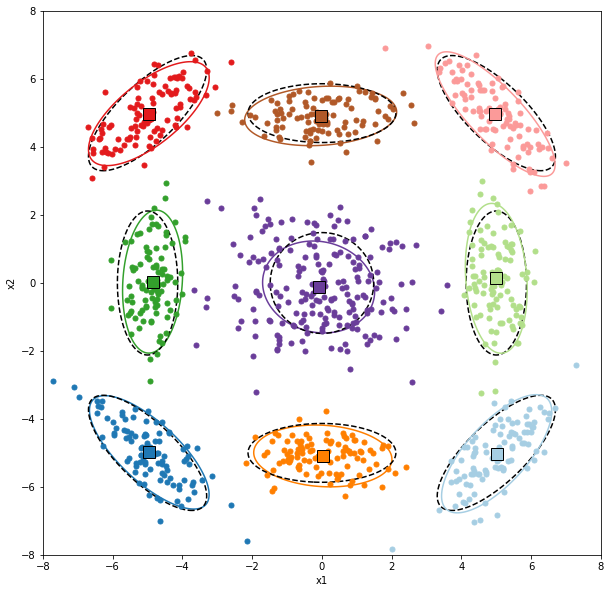

In [196]:
est_memberships = np.argmax(membership_probs, axis=1)

plt.figure(figsize=(10, 10))
plot_current_state(centroids, est_memberships, points, est_class_cov, class_means, class_cov)
plt.show()